## some more slop from Chat GPT but does it work

#### first impresions are that it does

Use this to loop over all data in a directory and create these conc over time plots for any given sample

In [19]:
# Alexandrium Concentration vs Volume Analyzed (Jupyter Notebook Version)

import os
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

def extract_adc_headers(hdr_file_path):
    with open(hdr_file_path, 'r') as file:
        for line in file:
            if line.startswith('ADCFileFormat:'):
                header_line = line.strip().split(':', 1)[1]
                headers = [h.strip() for h in header_line.split(',')]
                return headers
    raise ValueError('ADCFileFormat not found in header file.')

def load_adc_data(adc_file_path, hdr_file_path):
    headers = extract_adc_headers(hdr_file_path)
    df = pd.read_csv(adc_file_path, header=None)
    df.columns = headers[:df.shape[1]]
    return df

def load_class_data(class_file_path):
    return pd.read_csv(class_file_path)

def process_pair(adc_df, class_df, class_name):
    class_df['RoiNumber'] = class_df['pid'].str.split('_').str[-1].astype(int)
    adc_df['RoiNumber'] = range(1, len(adc_df) + 1)
    merged_df = pd.merge(class_df, adc_df[['RoiNumber', 'RunTime', 'InhibitTime']], on='RoiNumber', how='left')
    merged_df['VolumeAnalyzed'] = (merged_df['RunTime'] - merged_df['InhibitTime']) / 240

    class_cols = [col for col in merged_df.columns if class_name in col]
    if not class_cols:
        print(f"No columns found for class: {class_name}")
        merged_df['isTarget'] = 0
    else:
        merged_df['isTarget'] = (merged_df[class_cols] > 0.95).any(axis=1).astype(int)

    merged_df['ClassConcentration'] = merged_df['isTarget'].cumsum()
    return merged_df

def run_analysis(data_dir, class_name, save_path=None ):
    data_path = Path(data_dir)
    all_data = []

    for hdr_file in data_path.rglob('*.hdr'):
        adc_file = hdr_file.with_suffix('.adc')
        class_file = hdr_file.with_name(hdr_file.stem + '_class_vNone.csv')

        if adc_file.exists() and class_file.exists():
            print(f'Processing: {hdr_file.stem}')
            adc_df = load_adc_data(adc_file, hdr_file)
            class_df = load_class_data(class_file)
            merged_df = process_pair(adc_df, class_df, class_name)
            merged_df['Source'] = hdr_file.stem
            merged_df['ClassConcentration'] = merged_df['ClassConcentration'] / merged_df['VolumeAnalyzed'].replace(0, pd.NA)
            all_data.append(merged_df)
        else:
            print(f'Skipping incomplete set for: {hdr_file.stem}')

    if not all_data:
        print('No valid data files found.')
        return

    combined_df = pd.concat(all_data, ignore_index=True)

    fig, ax1 = plt.subplots(figsize=(12, 7))
    colors = plt.cm.get_cmap('tab10', len(combined_df['Source'].unique()))
    source_to_color = {src: colors(i) for i, src in enumerate(combined_df['Source'].unique())}

    for src, group in combined_df.groupby('Source'):
        ax1.plot(group['RunTime'], group['ClassConcentration'], label=f'{src} ({class_name})', color=source_to_color[src], linestyle='-')

    ax1.set_xlabel('Run Time (minutes)')
    ax1.set_ylabel(f'{class_name} Concentration (count/mL)')
    ax1.tick_params(axis='y')

    ax2 = ax1.twinx()
    for src, group in combined_df.groupby('Source'):
        ax2.plot(group['RunTime'], group['VolumeAnalyzed'], label=f'{src} (Vol)', color=source_to_color[src], linestyle='--')

    ax2.set_ylabel('Volume Analyzed (mL)')
    ax2.tick_params(axis='y')

    fig.tight_layout()
    plt.title(f'{class_name} Concentration vs Volume Analyzed')
    fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.95), fontsize='small')
    plt.grid(True)
    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"Plot saved to: {save_path}")
    plt.show()

# Example usage in a notebook cell:
# run_analysis("./your_data_folder", "Alexandrium_catenella")


# Adding a new size distribution vs time function

In [20]:
def size_distribution_analysis(data_dir, class_name="", save_path=None):
    data_path = Path(data_dir)
    all_data = []

    for hdr_file in data_path.rglob('*.hdr'):
        adc_file = hdr_file.with_suffix('.adc')
        class_file = hdr_file.with_name(hdr_file.stem + '_class_vNone.csv')

        if adc_file.exists() and class_file.exists():
            print(f'Processing for size analysis: {hdr_file.stem}')
            adc_df = load_adc_data(adc_file, hdr_file)
            adc_df['Source'] = hdr_file.stem
            adc_df['RoiArea'] = adc_df['RoiHeight'] * adc_df['RoiWidth']

            if class_name:
                class_df = load_class_data(class_file)
                class_df['RoiNumber'] = class_df['pid'].str.split('_').str[-1].astype(int)
                adc_df['RoiNumber'] = range(1, len(adc_df) + 1)
                merged_df = pd.merge(adc_df, class_df, on='RoiNumber', how='left')
                class_cols = [col for col in merged_df.columns if class_name in col]
                if class_cols:
                    merged_df = merged_df[(merged_df[class_cols] > 0.95).any(axis=1)]
                adc_df = merged_df  # filtered by class

            all_data.append(adc_df[['RunTime', 'RoiArea', 'Source']])
        else:
            print(f'Skipping incomplete set for: {hdr_file.stem}')

    if not all_data:
        print('No valid ADC data found.')
        return

    combined_df = pd.concat(all_data, ignore_index=True)

    plt.figure(figsize=(12, 6))
    colors = plt.cm.get_cmap('tab10', len(combined_df['Source'].unique()))
    for i, (src, group) in enumerate(combined_df.groupby('Source')):
        plt.scatter(group['RunTime'], group['RoiArea'], alpha=0.5, label=src, color=colors(i))

    plt.xlabel('Run Time (minutes)')
    plt.ylabel('ROI Area (Height × Width)')
    plt.title('ROI Area vs Run Time')
    plt.legend(loc='best', fontsize='small')
    plt.grid(True)
    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"Plot saved to: {save_path}")
    plt.show()

In [2]:
#example useage of each function
# for directory that includes sets of .adc, .hrd, and class.csv files of several bins
#run_analysis('/date_directory' , 'class of interest'(optional), save_path = 'NameOfFig'(optional))
#size_distribution_analysis('/date_directory' , 'class of interest'(optional), save_path = 'NameOfFig'(optional))
# the save_path parameter will make the program save your plot to your working directory

'/Users/michaelstaiger/Desktop/IFCBData'

Processing: D20230707T231853_IFCB110
Processing: D20230716T200537_IFCB110
Processing: D20230704T185043_IFCB110
Processing: D20230707T225205_IFCB110
Processing: D20230707T220503_IFCB110


/var/folders/l8/3r0hwyy91wg_66xlwdssv2yr0000gn/T/ipykernel_70399/2026143738.py:68: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(combined_df['Source'].unique()))


Plot saved to: HorizontalSamplingTriposConc


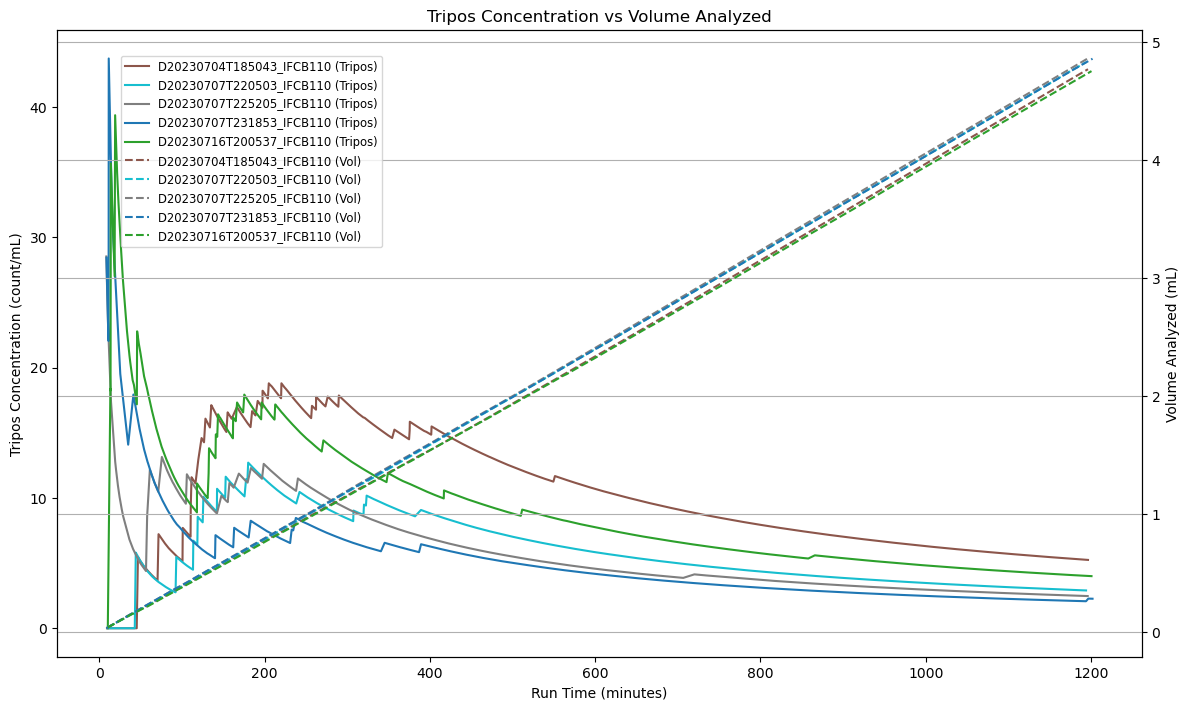

In [21]:
run_analysis("./h_sampling/", "Tripos", save_path='HorizontalSamplingTriposConc')

Processing for size analysis: D20230707T231853_IFCB110
Processing for size analysis: D20230716T200537_IFCB110
Processing for size analysis: D20230704T185043_IFCB110
Processing for size analysis: D20230707T225205_IFCB110
Processing for size analysis: D20230707T220503_IFCB110


/var/folders/l8/3r0hwyy91wg_66xlwdssv2yr0000gn/T/ipykernel_70399/4154413474.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(combined_df['Source'].unique()))


Plot saved to: HorizontalSampling_AllArea


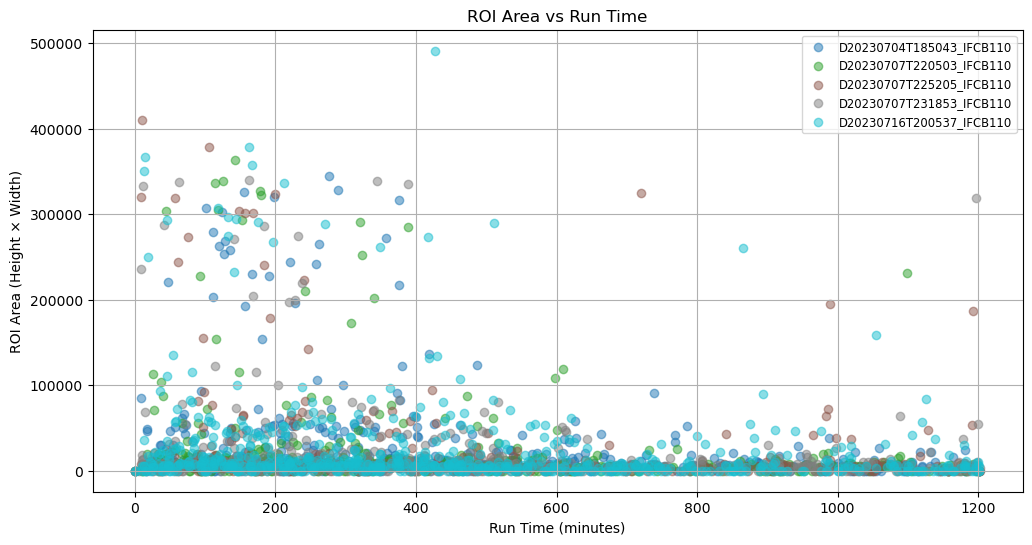

In [22]:
size_distribution_analysis('./h_sampling/',save_path='HorizontalSampling_AllArea')

Processing for size analysis: D20230707T231853_IFCB110
Processing for size analysis: D20230716T200537_IFCB110
Processing for size analysis: D20230704T185043_IFCB110
Processing for size analysis: D20230707T225205_IFCB110
Processing for size analysis: D20230707T220503_IFCB110


/var/folders/l8/3r0hwyy91wg_66xlwdssv2yr0000gn/T/ipykernel_70399/4154413474.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(combined_df['Source'].unique()))


Plot saved to: HSampling_TriposArea


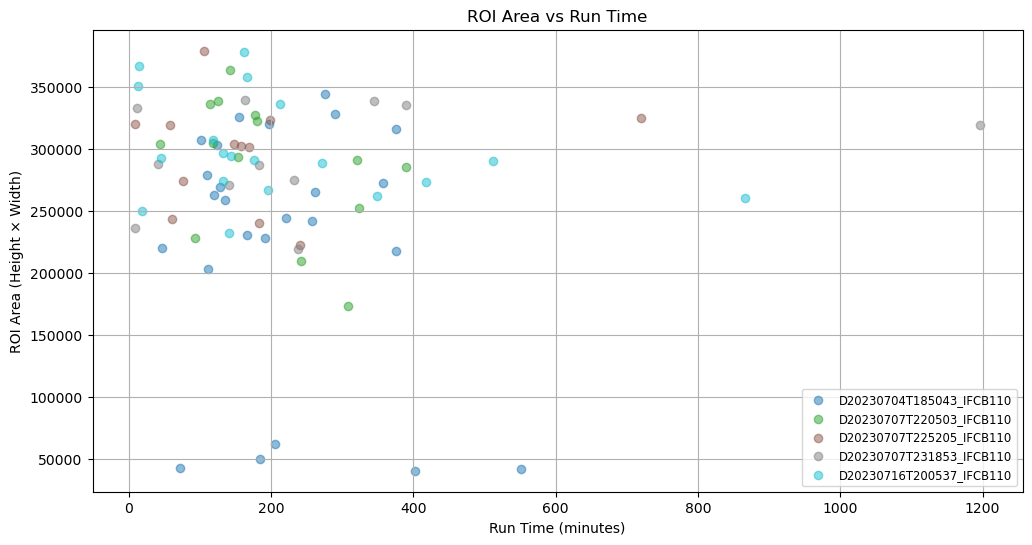

In [23]:
size_distribution_analysis('./h_sampling/','Tripos',save_path='HSampling_TriposArea')

Processing: D20240420T095637_IFCB124
Processing: D20240429T213320_IFCB124
Processing: D20240423T013135_IFCB124
Processing: D20240501T235832_IFCB124
Processing: D20240429T195718_IFCB124


/var/folders/l8/3r0hwyy91wg_66xlwdssv2yr0000gn/T/ipykernel_70399/2026143738.py:68: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(combined_df['Source'].unique()))


Plot saved to: AlexConcOverTime


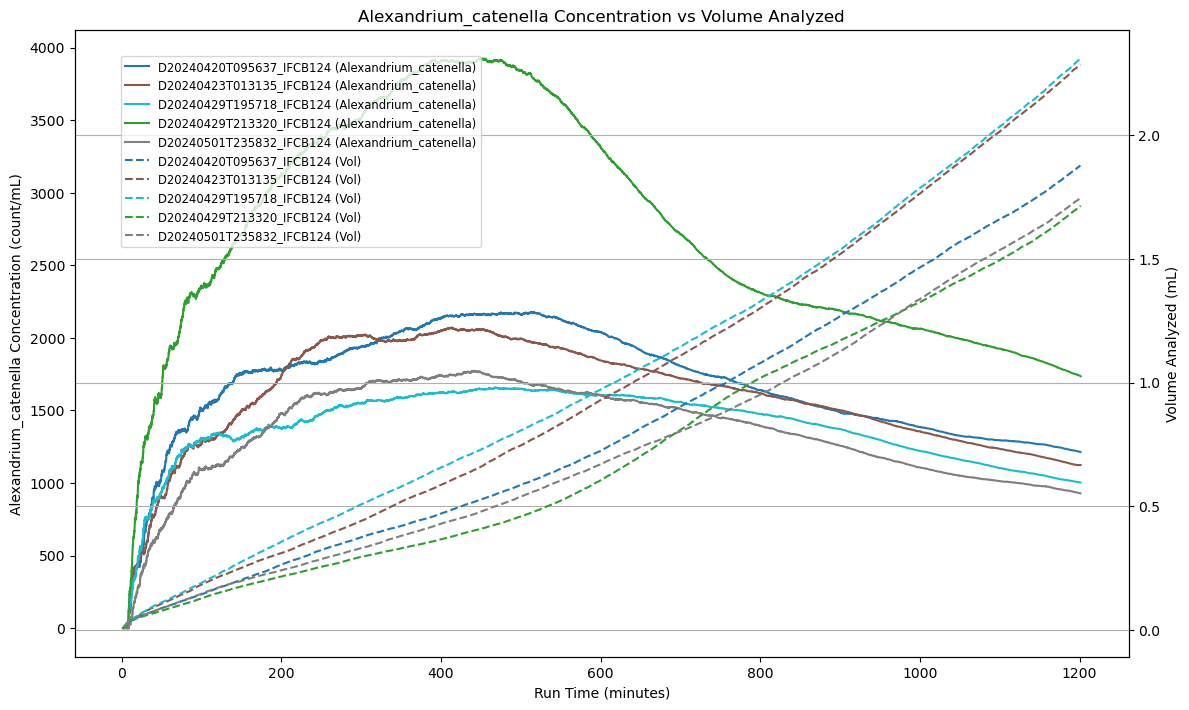

In [24]:
run_analysis("./AlexandriumTest/", "Alexandrium_catenella",save_path='AlexConcOverTime')


Processing for size analysis: D20240420T095637_IFCB124
Processing for size analysis: D20240429T213320_IFCB124
Processing for size analysis: D20240423T013135_IFCB124
Processing for size analysis: D20240501T235832_IFCB124
Processing for size analysis: D20240429T195718_IFCB124


/var/folders/l8/3r0hwyy91wg_66xlwdssv2yr0000gn/T/ipykernel_70399/1049388474.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(combined_df['Source'].unique()))


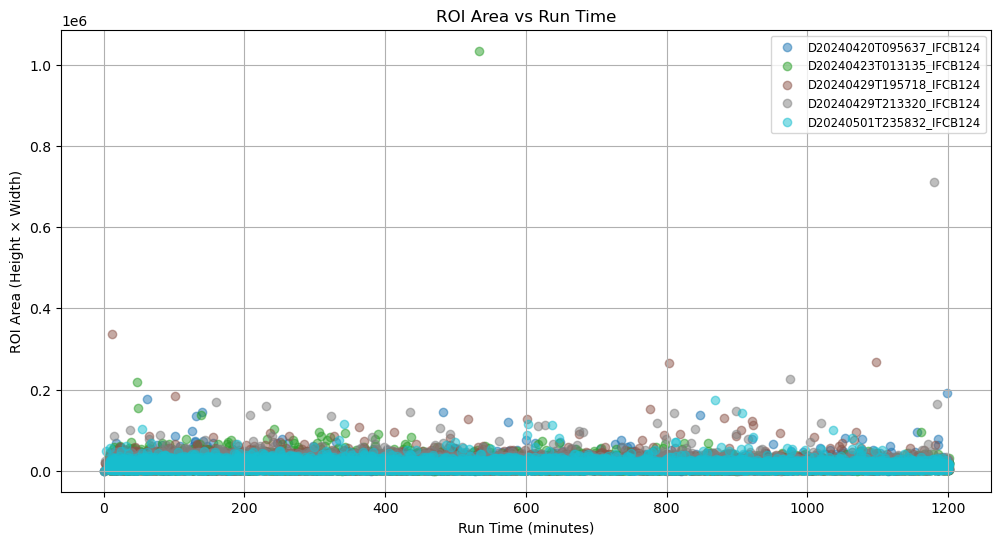

In [14]:
size_distribution_analysis('./AlexandriumTest/')

Processing for size analysis: D20240420T095637_IFCB124
Processing for size analysis: D20240429T213320_IFCB124
Processing for size analysis: D20240423T013135_IFCB124
Processing for size analysis: D20240501T235832_IFCB124
Processing for size analysis: D20240429T195718_IFCB124


/var/folders/l8/3r0hwyy91wg_66xlwdssv2yr0000gn/T/ipykernel_70399/4154413474.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(combined_df['Source'].unique()))


Plot saved to: AlexAreaOverTime


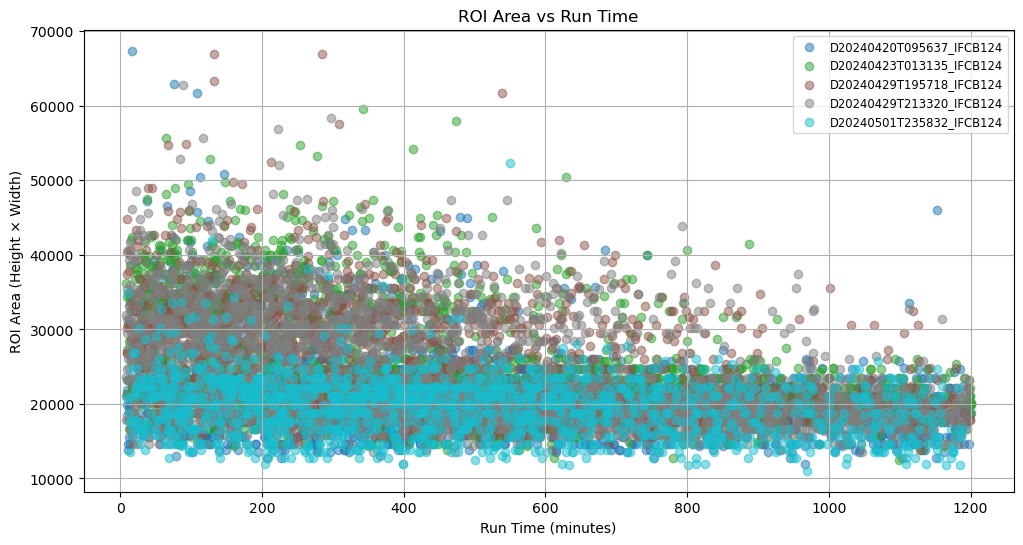

In [25]:
size_distribution_analysis('./AlexandriumTest/', "Alexandrium_catenella", save_path='AlexAreaOverTime')